In [1]:
# 首先 import 一些主要的包
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torch.utils.data as Data


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


# 获取文件名
file_name = 'train_data.npy'

# 读取数组
data = np.load(file_name)


# 生成题目所需的训练集合
def generate_data(data):
    # 记录 data 的长度
    n = data.shape[0]

    # 目标是生成可直接用于训练和测试的 x 和 y
    x = []
    y = []

    # 建立 (14 -> 1) 的 x 和 y
    for i in range(15, n):
        x.append(data[i - 15: i - 1])
        y.append(data[i])

    # 转换为 numpy 数组
    x = np.array(x)
    y = np.array(y)

    return x, y


x, y = generate_data(data)
x = torch.tensor(x, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

# 将 y 转化形状
y = torch.unsqueeze(y, dim=1)
print(x.shape, y.shape)

# 样本总数
num_samples = x.shape[0]
num_train = round(num_samples * 0.8)
num_valid = round(num_samples * 0.1)
num_test = num_samples - num_train - num_valid

dataset = Data.TensorDataset(x, y)
train_data, valid_data, test_data = Data.random_split(dataset, (num_train, num_valid, num_test))

batch_size = 512
train_loader = Data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_loader = Data.DataLoader(train_data, batch_size=batch_size, shuffle=False)
test_loader = Data.DataLoader(train_data, batch_size=batch_size, shuffle=False)


def compute_mae(y_hat, y):
    """
    :param y_hat: 用户的预测值
    :param y: 标准值
    :return: MAE 平均绝对误差 mean(|y*-y|)
    """
    return torch.mean(torch.abs(y_hat - y))


def compute_mape(y_hat, y):
    """
    :param y_hat: 用户的预测值
    :param y: 标准值
    :return: MAPE 平均百分比误差 mean(|y*-y|/y)
    """
    return torch.mean(torch.abs(y_hat - y)/y)


def evaluate_accuracy(data_loader, model):
    """
    :param data_loader: 输入的 DataLoader
    :param model: 用户的模型
    :return: 对应的 MAE 和 MAPE
    """
    # 初始化参数
    mae_sum, mape_sum, n = 0.0, 0.0, 0

    # 对每一个 data_iter 的每一个 x,y 进行计算
    for x, y in data_loader:
        x = x.to(device)
        # 计算模型得出的 y_hat
        y_hat = model(x)

        # 计算对应的 MAE 和 RMSE 对应的和，并乘以 batch 大小
        mae_sum += compute_mae(y_hat, y) * y.shape[0]
        mape_sum += compute_mape(y_hat, y) * y.shape[0]

        # n 用于统计 DataLoader 中一共有多少数量
        n += y.shape[0]

    # 返回时需要除以 batch 大小，得到平均值
    return mae_sum / n, mape_sum / n

torch.Size([1984, 14]) torch.Size([1984, 1])


In [2]:
# 输入的数量是前 14 个交易日的收盘价
num_inputs = 14
# 输出是下一个交易日的收盘价
num_outputs = 1
# 隐藏层的个数
num_hiddens = 128


# 建立一个稍微复杂的 LSTM 模型
class LSTM(nn.Module):
    def __init__(self, num_hiddens, num_outputs):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(
            input_size=1,
            hidden_size=num_hiddens,
            num_layers=1,
            batch_first=True
        )
        self.fc = nn.Linear(num_hiddens, num_outputs)

    def forward(self, x):
        x = x.view(x.shape[0], -1, 1)
        r_out, (h_n, h_c) = self.lstm(x, None)
        out = self.fc(r_out[:, -1, :])  # 只需要最后一个的output
        return out


lstm = LSTM(num_hiddens, num_outputs).to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(lstm.parameters(), lr=1e-3)


# 用于绘图用的信息
train_losses, valid_losses, train_maes, train_mapes, valid_maes, valid_mapes = [], [], [], [], [], []

# 循环 num_epochs 次
epochs = 200
for epoch in range(epochs):
    # 初始化参数
    train_l_sum, n = 0.0, 0
    # 初始化时间
    start = time.time()

    lstm.train()

    # 对训练数据集的每个 batch 执行
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)

        y_hat = lstm(x)
        loss = loss_fn(y_hat, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_l_sum += loss.item() * y.shape[0]

        # 计数一共有多少个元素
        n += y.shape[0]

    # 模型开启预测状态
    lstm.eval()

    # 同样的，我们可以计算验证集上的 loss
    valid_l_sum, valid_n = 0, 0
    for x, y in valid_loader:
        x, y = x.to(device), y.to(device)
        y_hat = lstm(x)
        loss = loss_fn(y_hat, y)

        # 对 loss 求和（在下面打印出来）
        valid_l_sum += loss.item() * y.shape[0]

        # 计数一共有多少个元素
        valid_n += y.shape[0]

    # 对验证集合求指标
    # 这里训练集其实可以在循环内高效地直接算出，这里为了代码的可读性牺牲了效率
    train_mae, train_mape = evaluate_accuracy(train_loader, lstm)
    valid_mae, valid_mape = evaluate_accuracy(valid_loader, lstm)
    if (epoch + 1) % 10 == 0:
        print(
            'epoch %d, train loss %.6f, valid loss %.6f, train mae %.6f, mape %.6f, valid mae %.6f,mape %.6f, time %.2f sec'
            % (epoch + 1, train_l_sum / n, valid_l_sum / valid_n, train_mae, train_mape, valid_mae, valid_mape,
               time.time() - start))

    # 记录绘图有关的信息
    train_losses.append(train_l_sum / n)
    valid_losses.append(valid_l_sum / valid_n)
    train_maes.append(train_mae)
    train_mapes.append(train_mape)
    valid_maes.append(valid_mae)
    valid_mapes.append(valid_mape)


epoch 10, train loss 73.712871, valid loss 69.212639, train mae 5.730372, mape 0.470865, valid mae 5.730372,mape 0.470865, time 0.54 sec
epoch 20, train loss 50.678994, valid loss 50.184787, train mae 5.391555, mape 0.614828, valid mae 5.391555,mape 0.614828, time 0.56 sec
epoch 30, train loss 34.254611, valid loss 32.067333, train mae 3.596236, mape 0.334074, valid mae 3.596236,mape 0.334074, time 0.56 sec
epoch 40, train loss 14.542577, valid loss 13.836478, train mae 1.739414, mape 0.094669, valid mae 1.739414,mape 0.094669, time 0.56 sec
epoch 50, train loss 8.587613, valid loss 8.349562, train mae 1.272145, mape 0.071487, valid mae 1.272145,mape 0.071487, time 0.55 sec
epoch 60, train loss 5.808437, valid loss 5.721476, train mae 1.071693, mape 0.066691, valid mae 1.071693,mape 0.066691, time 0.58 sec
epoch 70, train loss 4.161673, valid loss 4.044752, train mae 0.818125, mape 0.050916, valid mae 0.818125,mape 0.050916, time 0.56 sec
epoch 80, train loss 3.182750, valid loss 3.131

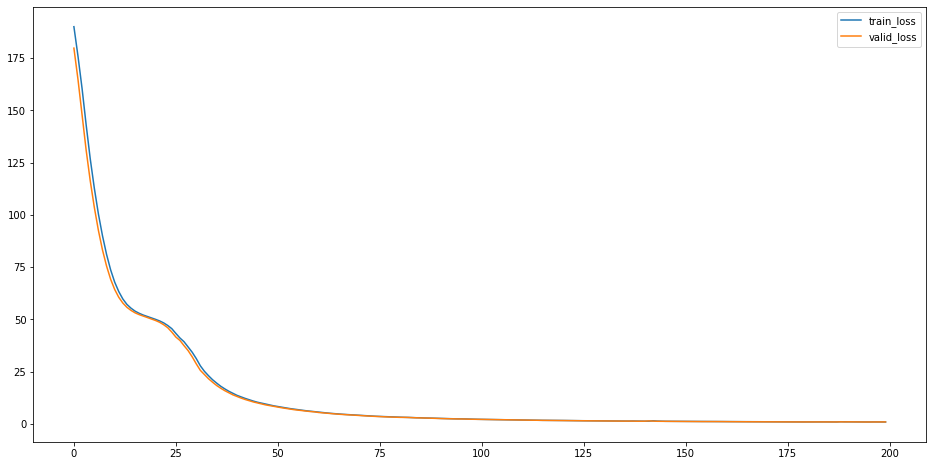

In [3]:
# 新建一个图像
plt.figure(figsize=(16,8))

# 绘制 train_loss 曲线
plt.plot(train_losses, label='train_loss')

# 绘制 valid_loss 曲线
plt.plot(valid_losses, label='valid_loss')

# 展示带标签的图像
plt.legend()

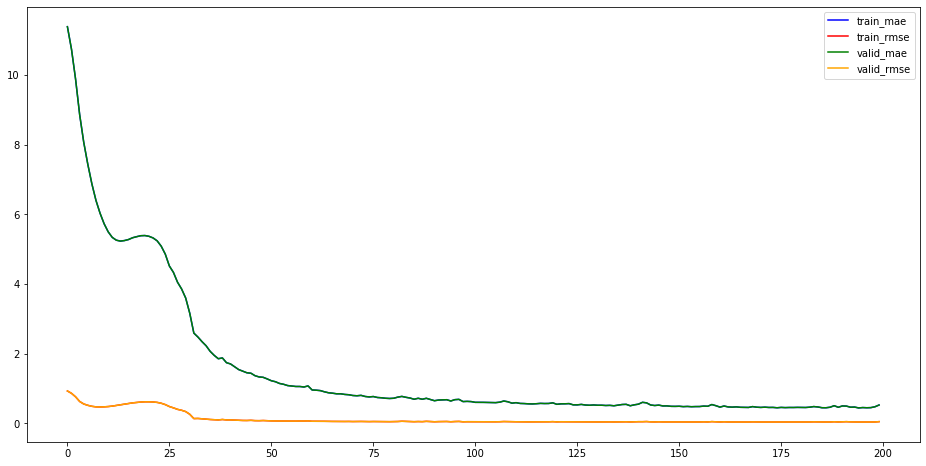

In [4]:
# 新建一个图像
plt.figure(figsize=(16,8))

# 绘画结点
plt.plot(train_maes, c='blue', label='train_mae')

plt.plot(train_mapes, c='red', label='train_rmse')

plt.plot(valid_maes, c='green', label='valid_mae')

plt.plot(valid_mapes, c='orange', label='valid_rmse')

# 展示图像
plt.legend()

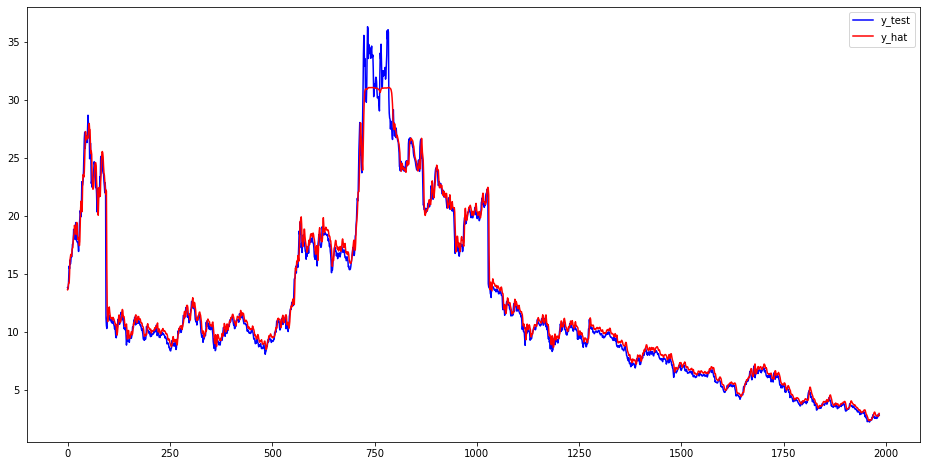

In [6]:
# 新建一个图像
plt.figure(figsize=(16,8))

# 预测结果
x_test, y_test = test_data.dataset.tensors
y_hat = lstm(x_test).detach()

# 绘画某些结点第一天的情况
plt.plot(y_test, c='blue', label='y_test')
plt.plot(y_hat, c='red', label='y_hat')

# 展示图像
plt.legend()